## Processing batches of data

As most deep learning workflows benefit greatly from running on machines with GPUs that can process data in parallel, during model training the data is passed in batches of samples to the network instead of processing each sample sequentially. Torch offers great support for this which builds on top of a provided dataset.
For convenience, the dataset class introduced in the previous notebook is part of the data module and we can now easily import it.

In [1]:
from torch.utils.data import DataLoader
from data import DSBData, get_dsb2018_train_files

In [2]:
train_img_files, train_lbl_files = get_dsb2018_train_files()

train_data = DSBData(
    image_files=train_img_files,
    label_files=train_lbl_files,
    target_shape=(256, 256)
)

print(len(train_data))

100%|██████████████████████████████████████| 382/382 [00:15<00:00, 25.37it/s]

232


In [3]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [4]:
for batch_idx, (batch_images, batch_labels) in enumerate(train_loader):
    print("Batch", batch_idx, batch_images.shape, batch_labels.shape)
    #break

Batch 0 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
Batch 1 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
Batch 2 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
Batch 3 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
Batch 4 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
Batch 5 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
Batch 6 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
Batch 7 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


## Neural network architecture

For semantic segmentation problems, a specific convolutional neural network architecture, i.e. a defined sequence of operations (also called layers) involving convolutional filters, data aggregation via pooling and nonlinear activation functions, has been demonstrated to work well across a wide range of image domains. This architecture is called UNet and its basic structure is shown below. (Image taken from [here](https://github.com/HarisIqbal88/PlotNeuralNet/blob/master/examples/Unet_Ushape/Unet_ushape.pdf).)

<img src="unet.png" alt="Drawing" style="height: 400px;"/>

As this is rather cumbersome to implement directly, we will use the [MONAI](https://monai.io/) library, which provides a nice torch implementation of this architecture.

In [5]:
import matplotlib.pyplot as plt
import torch

from monai.networks.nets import BasicUNet

In [6]:
BasicUNet?

Init signature:
BasicUNet(
    spatial_dims: 'int' = 3,
    in_channels: 'int' = 1,
    out_channels: 'int' = 2,
    features: 'Sequence[int]' = (32, 32, 64, 128, 256, 32),
    act: 'str | tuple' = ('LeakyReLU', {'negative_slope': 0.1, 'inplace': True}),
    norm: 'str | tuple' = ('instance', {'affine': True}),
    bias: 'bool' = True,
    dropout: 'float | tuple' = 0.0,
    upsample: 'str' = 'deconv',
)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x

In [7]:
model = BasicUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    features=[16, 16, 32, 64, 128, 16],
    act="relu",
    norm="batch",
    dropout=0.25,
)
print(model)

BasicUNet features: (16, 16, 32, 64, 128, 16).
BasicUNet(
  (conv_0): TwoConv(
    (conv_0): Convolution(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (D): Dropout(p=0.25, inplace=False)
        (A): ReLU()
      )
    )
    (conv_1): Convolution(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (D): Dropout(p=0.25, inplace=False)
        (A): ReLU()
      )
    )
  )
  (down_1): Down(
    (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convs): TwoConv(
      (conv_0): Convolution(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

We can now feed a batch of images directly through the model to obtain predictions. Note however, that those will likely not be usable for segmentation as the model has not been trained yet and model parameters are initialized randomly.
Note that the model outputs are of the same shape as the model inputs. Because the UNet consists entirely of convolutional operations, it is (to a degree) shape invariant and can process arbitrary input sizes. It is however recommended to work with resolutions that are divisible by 16, as the input resolution is halved in each of the four downsampling blocks.

In [8]:
batch_preds = model(batch_images)
print(batch_preds.shape)

torch.Size([8, 1, 256, 256])


Text(0.5, 1.0, 'Predictions')

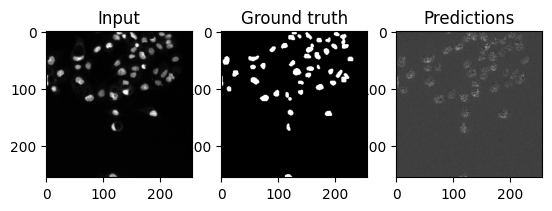

In [9]:
plt.subplot(131)
plt.imshow(batch_images[0, 0].numpy(), cmap="gray")
plt.title("Input")

plt.subplot(132)
plt.imshow(batch_labels[0, 0].numpy(), cmap="gray")
plt.title("Ground truth")

plt.subplot(133)
plt.imshow(batch_preds.detach()[0, 0].numpy(), cmap="gray")
plt.title("Predictions")

In [10]:
# different sized dummy input should be processable as well
dummy_batch = torch.zeros(8, 1, 512, 512)
dummy_preds = model(dummy_batch)
print(dummy_preds.shape)

torch.Size([8, 1, 512, 512])


In [11]:
# different sized dummy input that is not divisible by 16, still produces output of same shape
dummy_batch = torch.zeros(8, 1, 114, 87)
dummy_preds = model(dummy_batch)
print(dummy_preds.shape)

torch.Size([8, 1, 114, 87])


Moreover, the model output range is not limited because in the output layer, no nonlinear activation was used. In order to make the output usable for segmentation purposes, we apply a sigmoid activation function per pixel

In [12]:
print(batch_preds.min(), batch_preds.max())

tensor(-4.1844, grad_fn=<MinBackward1>) tensor(12.0578, grad_fn=<MaxBackward1>)


In [13]:
batch_preds_seg = torch.nn.functional.sigmoid(batch_preds)
print(batch_preds_seg.min(), batch_preds_seg.max())

tensor(0.0150, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)


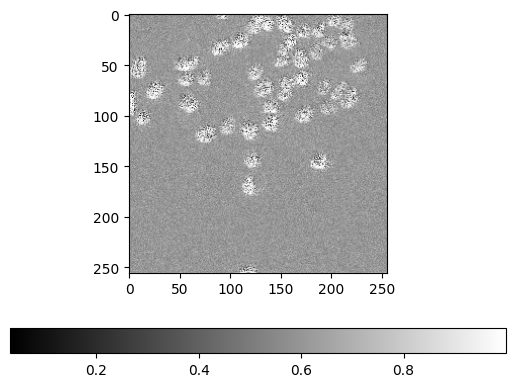

In [14]:
plt.imshow(batch_preds_seg.detach()[0, 0], cmap="gray")
plt.colorbar(orientation="horizontal")

In order to obtain binary (0/1) predictions, a straightforward approach would be to use thresholding at 0.5

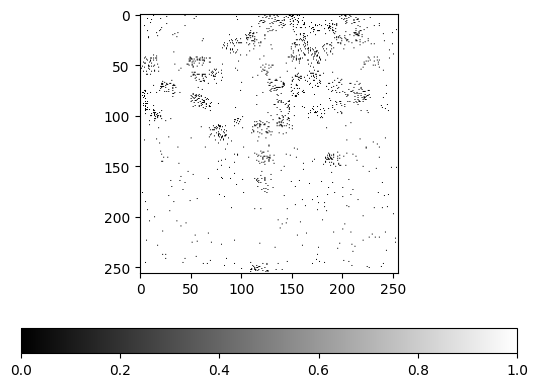

In [15]:
batch_preds_seg_binary = (batch_preds_seg > 0.5).to(torch.uint8)
plt.imshow(batch_preds_seg_binary.detach()[0, 0], cmap="gray")
plt.colorbar(orientation="horizontal")